# Predicting Academy Award Best Picture Winners

## Introduction 

The academy awards are a yearly award ceremony honoring the best movies of the year and those who contributed to their making. The penultimate award is the academy award for best picture, which is given to the best movie of the year from a preannounced set of nominees. Every year, there is substantial speculation about which movie will win the award.  The goal of this project is to predict academy award for best picture winners from a academy award for best picture nominated movies. 

Data is scraped from wikipedia and imdb. The features included in this dataset and analysis are: Director, Producer, Written by/Screenplay by, Cast, Budget, Box Office, language, runtime, year, rating, genres and plot. A number of binary classification methods are considered: Logistic regression, Support Vector Machines, K-th Nearest Neighbors, Random Forests and Adaboost. These methods are implemented, analyzed and compared. While a variety of these variables factor in exploratory data analysis and logistic regression analysis, textual analysis of the plot is the primary component of binary classification efforts, but all relevant features are included in the construction of a simularity measure (kernel). 

These classification and prediction algorithms, as well as the general analysis of this project, could be used to predict which movies, particularly movie plots, are most likely to be successful at the academy awards. Production company executives could use these algorithms to assess the quality of scripts. 

This notebook has four parts: Web Scraping and Data retrieval, Exploratory Data Analysis, Classification and Prediction and Conclusion. 



## Web Scraping and Data Retrieval

Data is scraped from wikipedia pages for each academy award nominated movie. The variables collected include: Movie Name, Director, Producer, Written By, Screenplay By, Budget, Box Office, Starring, Languages, A brief description of the film, Plot Summary and Running Time. From imdb, the following variables are scraped: Year, Genre(s) and imdb rating. The code in this section does not have to be run, I have already run this code and exported the data into an attached excel file since the web scraping code takes quite a few minutes and isnt possible without an internet connection. Note: Wikipedia pages are subject to change over time. Changes in formatting on some pages may lead to missing values in the scraping.

The following function takes the end of a wikipedia url such as "/wiki/Three_Coins_in_the_Fountain_(film)" and outputs information as an array. 

In [317]:
import requests
from bs4 import BeautifulSoup
import pandas

In [318]:
def movieinfo(x):
	"""Returns a list of movie info according to list of things (plus description)
	INPUT: wikipedia url ending for a movie /wiki/movie_name
	OUTPUT: An array including: name, "Directed by", "Produced by", "Written by", "Screenplay by", "Music by", "Budget", "Box office", "Starring", "Distributed by", "Country", "Language"
	, description, plot, Premiere Date and Running Time"""
	link = "https://en.wikipedia.org" + x
	stuff = requests.get(link) #Pulls Link
	soup = BeautifulSoup(stuff.text, 'html.parser') #Parses HTML into Beautiful Soup
	listofthings = [ "Directed by", "Produced by", "Written by", "Screenplay by", "Music by", "Budget", "Box office", "Starring", "Distributed by", "Country", "Language"]
	result=[]
	for i in listofthings: #Adds the items in list of things
		try:
			for th in soup.find(text=i).parent.find_next_siblings():
				result.append(th.text) #append the text that corresponds to i, in the list of things
		except:
			result.append("NA")
	result.append(soup.find("p").get_text()) #Appending the description
	try: #Addings Premiere Date
		RDate = soup.find("span").get_text()
		RDate = RDate[RDate.index("("):RDate.index(")")]
		result.append(RDate)

	except:
		result.append("NA")
	try:	#Adds Running Time	
		[result.append(rtime.text) for rtime in soup.find(text="Running time").parent.parent.find_next_siblings()]
	except:
		result.append("NA") 

	try: #Adds plot
		wholepage = soup.get_text()
		#result.append(wholepage)
		result.append(wholepage[wholepage.index("Plot[edit]")+len("Plot[edit]"):wholepage.index("Cast[edit]")])
	except:
		result.append("NA")

	return result

The following code scrapes the wikipedia page for academy award for best picture, to get a list of academy award for best picture nominated movies. More acurately, it scrapes this page for the wikipedia url endings, which is what is inputed to the movieinfo function.  

In [319]:
link = "https://en.wikipedia.org/wiki/Academy_Award_for_Best_Picture"
stuff = requests.get(link)
soup2 = BeautifulSoup(stuff.text, 'html.parser')

listofmovies = [] 
listofwinners = []
for child in soup2.findAll("tr", style="background:#FAEB86"):
	listofmovies.append(child.find("a")["href"]) #Appending the wikipedia website for best pictures
	listofwinners.append(child.find("a")["href"]) #Appending the wikipedia website to list of best picture winners
	for child2 in child.find_next_siblings():
		listofmovies.append(child2.find("a")["href"]) ##Appending the wikipedia website for non best pictures
#Non best picturs are added seperatly, they are under next siblings of child, while child (best picture) is the first sibling
listofmovies=list(set(listofmovies)) #Remove Duplicates

#Remove year_in_film from list of films (This is a heading in wikipedia which is incorrectly added to listofmovies as a movie, it is removed here)
newlistofmovies = []
for i in range(len(listofmovies)):
	movie = listofmovies[i]
	if "in_film" not in  movie:
		newlistofmovies.append(movie)

listofmovies = newlistofmovies

The following code iterates through the best picture nominees (listofmovies) and scrapes the movie information using the movieinfo function.

In [ ]:
#Runs through all the movies and gets the movie info Combining into one long list
#WARNING: Takes about 3 minutes
arrayofmovieinfo=[]
for movie in listofmovies:
	#print(movie)
	try:
		newmovie=[movie]+ movieinfo(movie) 
		arrayofmovieinfo.append(newmovie)
	except:
		newmovie=[movie] + ["Didn't Work"]
		arrayofmovieinfo.append(newmovie)
		continue
#print(arrayofmovieinfo)


Creating variable that is 1 if the movie was a winner:

In [ ]:
#Create Variable which is 1 if the movie was a winner:
for i in range(len(listofmovies)):
	if listofmovies[i] in listofwinners:
		arrayofmovieinfo[i].append(1)
	else:
		arrayofmovieinfo[i].append(0)

The name variable is changed from wikipedia url endings to actual movie names (strings).

In [ ]:
#Removing the stuff needed to get the wikipedia page
for i in range(len(arrayofmovieinfo)):
	arrayofmovieinfo[i][0]= arrayofmovieinfo[i][0].replace("/wiki/", "")
	arrayofmovieinfo[i][0] = arrayofmovieinfo[i][0].replace("_", " ")
	arrayofmovieinfo[i][0] = arrayofmovieinfo[i][0].replace("%27", "'")
	if "(" in arrayofmovieinfo[i][0] :
		arrayofmovieinfo[i][0] = arrayofmovieinfo[i][0][0:arrayofmovieinfo[i][0].index("(")]


The scraped data is turned into a pandas dataframe and exported to an excel file. Note: I commented out the code to write to an excel file, since I have already done this to save time. I instead just read in the data from this excel file. 

In [ ]:
df = pandas.DataFrame(arrayofmovieinfo)
from pandas import ExcelWriter
writer = ExcelWriter('academy.xlsx')
df.to_excel(writer,'Sheet1')
writer.save()

The following cell scrapes data from imdb. the scraped variables are name, genre(s), year and imdb rating. The data is exported to an excel file. 

In [ ]:
names = []
rating = []
year = []
genres = []

links = ["https://www.imdb.com/list/ls057163321/","https://www.imdb.com/list/ls057163321/?sort=list_order,asc&st_dt=&mode=detail&page=2","https://www.imdb.com/list/ls057163321/?sort=list_order,asc&st_dt=&mode=detail&page=3","https://www.imdb.com/list/ls057163321/?sort=list_order,asc&st_dt=&mode=detail&page=4","https://www.imdb.com/list/ls057163321/?sort=list_order,asc&st_dt=&mode=detail&page=5","https://www.imdb.com/list/ls057163321/?sort=list_order,asc&st_dt=&mode=detail&page=6"]
for link in links:
	stuff = requests.get(link) #Pulls Link
	soup = BeautifulSoup(stuff.text, 'html.parser') 
	dat = soup.find_all("div", {"class": "lister-item mode-detail"})
	dat = [i.get_text() for i in dat]
	dat = [" ".join(i.split()) for i in dat]
	for movie in dat:
		if "0 Rate" in movie:
			i = movie[0:movie.index("0 Rate")]
			names.append(i[i.index(".")+2:i.index(" (")])
			rating.append(i[-4:-1])
			yearpos = i[i.index("(")+1:i.index(")")]
			if yearpos == 'II' or yearpos == 'I' :
				if " (2" in i:
					year.append(i[i.index(" (2")+2:i.index(" (2")+6])
				if " (1" in i:
					year.append(i[i.index(" (1")+2:i.index(" (1")+6])
			else:
				year.append(yearpos)
			genres.append(i[i.index("min |")+len("min |"):-5])
		else:
			names.append("NA")
			rating.append("NA")
			year.append("NA")
			genres.append("NA")

#Birdman movie data is incorrect, must be fixed manually
names[71] = " Birdman or (The Unexpected Virtue of Ignorance)"
year[71] = "2014"
genres[71] = "Comedy, Drama"
rating[71] = "7.7"


data = np.array([names,year,rating,genres])

df = pandas.DataFrame(np.transpose(data))

from pandas import ExcelWriter

writer = ExcelWriter('academyimdb.xlsx')
df.to_excel(writer,'Sheet1')
writer.save()

The following cell reads the data from the spreadsheet for academy.xlsx and academyimdb.xlsx and merges them. It also corrects some incorrect data and errors.

In [ ]:
dfimdb = pd.read_excel("academyimdb.xlsx",sheet_name='Sheet1' ) #Import imdb data
dfwiki = pd.read_excel("academy.xlsx",sheet_name='Sheet1' ) #Import wiki data



dfimdb = dfimdb.as_matrix()
dfwiki = dfwiki.as_matrix()


dfimdb[452] = ['49th Parallel', "NA", "NA", "NA"] # There is a missing value that needs to be changed from NaN to "NA"
match=[[4,542],[70,166],[404,485],[405,522],[418,210],[446,544],[108,53],[129,57],[136,515],[167,121],[168,541],[175,227],[176,543],[197,394],[228,203],[229,324],[286,545],[287,540],[328,111],[352,437],[354,99],[459,67],[471,189]]
for (i,j) in match: #Changing the misnamed in the wiki dataset
	dfwiki[j][0]=dfimdb[i][0]
rats=[]
notrats=[]

#Cycles through the data and where the names match, the indexes are stored in rats
for i in range(0,540): 
	for j in range(0,540):
		if dfimdb[i][0].strip() == dfwiki[j][0].strip():
			rats.append([i,j])
		else:
			continue
wikiratsset = set([j for (i,j) in rats])
#print(wikiratsset)
notrats = set(range(546)) - wikiratsset
print(notrats)
#Pulls the matching entries (whose indices are stored in rats) into a final dataframe
final=[]
for (i,j) in rats:
		final.append(np.append(dfwiki[j],dfimdb[i]))


# 228 and 231 are duplicate observations caused by the issue of two movies called "Les Miserables" These observations are dropped
final.pop(228)
final.pop(230)

#Same issue with Romeo and Juliet, two nominated movies with that name, so i dropped the duplicates created by this issue
final.pop(318)
final.pop(318)
print(notrats)
[final.append(dfwiki[j]) for j in notrats] #Add wikidata for ones who didnt match






#Write to Excel file
df = pd.DataFrame(final)

#writer = ExcelWriter('merged.xlsx')
#df.to_excel(writer,'Sheet1')
#writer.save()

While the above cells will scrape the data. We have already run them and stored the scraped data in the file "AAdata.xlsx"

## Import the Data

In [1]:
import pandas as pd
import numpy as np
data = pd.read_excel("AAdata.xlsx", sheet_name='Sheet1')
n = data.shape[0]
data.shape

(546, 15)

In [2]:
#data.columns=["Name","Director", "Producer", "Written by", "Screenplay by","Budget", "Box Office", "Cast","Language","Runtime","Plot","Winner","Year","Rating","Generes"]
data = data.as_matrix()

## Training/ Test Data Split
In this section, a training/test split is created. A 70-30 split is chosen.

In [3]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.3, random_state=8543259)
print(train.shape)
print(test.shape)
n = train.shape[0]
nt = test.shape[0]
testindex = []
trainindex = []
for i in range(data.shape[0]):
    for j in range(n):
        if data[i][0]==train[j][0] and data[i][1]==train[j][1]:
            trainindex.append(i)
for i in range(data.shape[0]):
    if i not in trainindex:
        testindex.append(i)

(382, 15)
(164, 15)


# Data Cleaning
A name ending in "vect" is given to each cleaned and vectorized portion of data. The matrices or vectors ending in vect consist only of cleaned data as numbers, rather than strings or uncleaned data.

## Director: Train
The variables are changed to lists of directors.

In [4]:
for i in range(n):
    train[i][1]=train[i][1].split("\n") #splits string by line breaks (this divides it into directors)
    train[i][1]=list(filter(None, train[i][1])) #Takes out the empty strings 

The following cell extracts a list of directors that appear more than once in train and puts them in keepdirect. Directors that only appear once will be disregarded.

In [5]:
listofdirect = []
[listofdirect.append(train[i][1]) for i in range(n)]
masterlist = []
for i in listofdirect:
    for item in i:
        masterlist.append(item)

keepdirect = []
for item in masterlist:
    if masterlist.count(item)>1:
        keepdirect.append(item) #put the directors that show up more than once in keep
keepdirect = list(set(keepdirect)) #remove duplicates
print(len(keepdirect))

85


77 directors have directed more than one academy award nominated movie in the training set. The following cell creates a matrix where each row is a movie and each column vector is one of these directors. The entry in the matrix is one if the director directed that movie and zero otherwise. 

In [6]:

traindirectvect = [ [] for i in range(n) ]
for i in range(n):
    for j in range(len(keepdirect)):
        traindirectvect[i].append( train[i][1].count(keepdirect[j]) )
np.array(traindirectvect).shape

(382, 85)

## Director: Test
In this section, the matrix of data on directors in the test set is created. For each movie, the entry is one if the directed directed that movie and zero otehrwise. 

In [7]:
for i in range(nt):
    test[i][1]=test[i][1].split("\n") #splits string by line breaks (this divides it into directors)
    test[i][1]=list(filter(None, test[i][1])) #Takes out the empty strings 

testdirectvect = [ [] for i in range(nt) ]
for i in range(nt):
    for j in range(len(keepdirect)):
        testdirectvect[i].append( test[i][1].count(keepdirect[j]) )
np.array(testdirectvect).shape

(164, 85)

## Producer: Train
The variables are changed to lists of directors.

In [8]:
for i in range(n):
    train[i][2]=train[i][2].split("\n") #splits string by line breaks (this divides it into producers)
    train[i][2]=list(filter(None, train[i][2])) #Takes out the empty strings

The following cell extracts a list of directors that appear more than once and puts them in keepprod. Producers that only appear once will be disregarded.

In [9]:
listofprod = []
[listofprod.append(data[i][2]) for i in range(n)]
masterlist = []
for i in listofprod:
    for item in i:
        masterlist.append(item)

keepprod = []
for item in masterlist:
    if masterlist.count(item)>1:
        #print(item,masterlist.count(item))
        keepprod.append(item) #put the directors that show up more than once in keep
keepprod = list(set(keepprod)) #remove duplicates
print(len(keepprod))

61


There are 61 producers that have produced more than one nominated film. The following cell creates a matrix where each row is a movie and each column is one of these producers. The entry in the matrix is one if the producer produced that movie and zero otherwise. 

In [10]:

trainprodvect = [ [] for i in range(n) ]
for i in range(n):
    for j in range(len(keepprod)):
        trainprodvect[i].append( train[i][1].count(keepprod[j]) )
np.array(trainprodvect).shape


(382, 61)

## Producer: Test

In [11]:
for i in range(nt):
    test[i][2]=test[i][2].split("\n") #splits string by line breaks (this divides it into producers)
    test[i][2]=list(filter(None, test[i][2])) #Takes out the empty strings
testprodvect = [ [] for i in range(nt) ]
for i in range(nt):
    for j in range(len(keepprod)):
        testprodvect[i].append( test[i][1].count(keepprod[j]) )
np.array(testprodvect).shape

(164, 61)

The trainprodvect and testprodvect variable is the variable that will actually be put into later algorithms (perhaps after kernel trick or dimensional reductin is applied).

## Written by and Screenplay by: Train
These variables are combined into a "Created by" variable. Each movie is either an original screenplay or an adapted screenplay. So each movie is missing for either Wirtten by or Screenplay by.

In [12]:
Createdby = [[train[i][3],train[i][4]] for i in range(n)]
newCreatedby = [[] for i in range(n)]
for i in range(n):
    for j in range(len(Createdby[i])):
        if pd.isna(Createdby[i][j])==False:
            newCreatedby[i].append(Createdby[i][j].split("\n")) #Combines written by and screenplay by
# for i in range(n):
#     for j in range(len(newCreatedby[i])):
newCreatedby = [item for sublist in newCreatedby for item in sublist] #Removes double listing
newCreatedby = [ list(filter(None, newCreatedby[i])) for i in range(n) ] #Removes empty strings

The following cell extracts a list of creators that appear more than once and puts them in keepcreate. Creators that only appear once will be disregarded.

In [13]:
listofcreat = []
[listofcreat.append(newCreatedby[i]) for i in range(n)]
masterlist = []
for i in listofcreat:
    for item in i:
        masterlist.append(item)
keepcreate = []
for item in masterlist:
    if masterlist.count(item)>1:
        #print(item,masterlist.count(item))
        keepcreate.append(item) #put the directors that show up more than once in keep
    #else:
        #print(item,masterlist.count(item))
keepcreate = list(set(keepcreate)) #remove duplicates
print(len(keepcreate))

92


There are 95 "creators" that have contributed in this way to more than one academy award nominated movie. The following cell creates a matrix where each row is a movie and each column is one of these creators. The entry in the matrix is one if the creator created that movie and zero otherwise. 

In [14]:
traincreatvect = [ [] for i in range(n) ]
for i in range(n):
    for j in range(len(keepcreate)):
        traincreatvect[i].append( newCreatedby[i].count(keepcreate[j]) )
np.array(traincreatvect).shape

(382, 92)

## Written by and Screenplay by: Test
Creates a matrix where the (i,j)th entry is 1 if the creator j created the ith movie. Only creators that appeared more than once in training set are used.

In [15]:
Createdby = [[test[i][3],test[i][4]] for i in range(nt)]
newCreatedby = [[] for i in range(nt)]
for i in range(nt):
    for j in range(len(Createdby[i])):
        if pd.isna(Createdby[i][j])==False:
            newCreatedby[i].append(Createdby[i][j].split("\n")) #Combines written by and screenplay by
# for i in range(n):
#     for j in range(len(newCreatedby[i])):
newCreatedby = [item for sublist in newCreatedby for item in sublist] #Removes double listing
newCreatedby = [ list(filter(None, newCreatedby[i])) for i in range(nt) ] #Removes empty strings


testcreatvect = [ [] for i in range(nt) ]
for i in range(nt):
    for j in range(len(keepcreate)):
        testcreatvect[i].append( newCreatedby[i].count(keepcreate[j]) )
np.array(testcreatvect).shape

(164, 92)

## Cast: Train
We turn this variable into a list of actors/actresses appearing.

In [16]:
for i in range(n):
    train[i][7]=train[i][7].split("\n") #splits string by line breaks (this divides it into list of actors/acrtresses)
    train[i][7]=list(filter(None, train[i][7])) #Takes out the empty strings 

The following cell extracts a list of actors that appear more than once and puts them in keepprod. Cast that only appear once will be disregarded.

In [17]:
listofact = []
[listofact.append(train[i][7]) for i in range(n)]
masterlist = []
for i in listofact:
    for item in i:
        masterlist.append(item)

keepact = []
for item in masterlist:
    if masterlist.count(item)>1:
        #print(item,masterlist.count(item))
        keepact.append(item) #put the actors that show up more than once in keep
keepact = list(set(keepact)) #remove duplicates
print(len(keepact))

371


There are 364 actors/actresses that have been in more than one nominated film (Note: This makes sense becaues movies can have a lot of actors).The following cell creates a matrix where each row is a movie and each column is one of these actors. The entry in the matrix is one if the actor participated in that movie and zero otherwise. 

In [18]:
trainactvect = [ [] for i in range(n) ]
for i in range(n):
    for j in range(len(keepact)):
        trainactvect[i].append( train[i][1].count(keepact[j]) )
np.array(trainactvect).shape

(382, 371)

## Cast: Test

In [19]:
for i in range(nt):
    test[i][7]=test[i][7].split("\n") #splits string by line breaks (this divides it into list of actors/acrtresses)
    test[i][7]=list(filter(None, test[i][7])) #Takes out the empty strings 
    
testactvect = [ [] for i in range(nt) ]
for i in range(nt):
    for j in range(len(keepact)):
        testactvect[i].append( test[i][1].count(keepact[j]) )
np.array(testactvect).shape

(164, 371)

## Budget and Box Office
These variables contain box office and budget numbers. However, they are structured as strings and need to be turned into integers. This is the 4th and 5th columns.

In [20]:
#[print(data[i][5],data[i][6]) for i in range(n)]

#exam = data[100][5]
def getnumber(exam):
    """This function takes a string as an input. It outputs the number inside the string that represents either box ofice or budget
    Missing values are set to unknown"""
    if pd.isna(exam)==True:
        return("unknown")
    if exam.find("₤")==-1 and exam.find("£")==-1:
        start = exam.find("$")
    if exam.find("£")>-1:
        start = exam.find("£")
    if exam.find("₤")>-1:
        start = exam.find("₤") #finds first pounds or dollar sign
    for i in range(start+1,len(exam)):
        if exam[i] not in ["0","1","2","3","4","5","6","7","8","9",",","."]: #first character after dollar sign that isnt part of numebr
            if exam[i]==exam[-1]:
                return(exam[start+1:i])
            if exam[i]=="–" or exam[i]=="-":
                if "million" in exam:
                    return(float(exam[start+1:i])*1000000)
                else:
                    return(float(exam[start+1:i].replace(',', '')))
                
            if exam[i+1]=="m" and exam[i+2]=="i": #this means its in millions
                return(float(exam[start+1:i])*1000000)
            else:
                return(exam[start+1:i])

for i in range(data.shape[0]): #replaces string in data with number
    data[i][5]=getnumber(data[i][5])
    data[i][6]=getnumber(data[i][6])



There are still a substantial amount of missing values. These will be inputed with the average for their year (most variation in box office and budget is from when the movie was made). The following cell creates a dictionary for box office and budget. The years are the tags in the dictionary and each tag corresponds to a list of box office or budge values for that year

In [21]:
years = [data[i][12] for i in range(data.shape[0])]
dbudget = {}
dbox = {}
for year in set(years):
    dbudget[year] = []
    dbox[year] = []
    for i in range(data.shape[0]):
        if data[i][12]==year:
            if type(data[i][5])==float: 
                dbudget[year].append(data[i][5])
            if type(data[i][6])==float:             
                dbox[year].append(data[i][6])
                          

In [22]:
data.shape

(546, 15)

The following cell creates a dictionary of average budget and box office by year.

In [23]:
dbudavg = {}
dboxavg = {}
for year in set(years):
    if len(dbudget[year])>0:
        dbudavg[year] = sum(dbudget[year])/float(len(dbudget[year]))
    else:
        dbudavg[year] = dbudavg[year-1]
for year in set(years):
    if len(dbox[year])>0:
        dboxavg[year] = sum(dbox[year])/float(len(dbox[year]))
    else:
        dboxavg[year] = dboxavg[year-1]

The following cell imputes the missing values and creates new vectors boxvector (for box office ) and budvector (for budget). These vectors have the box office and budget per movie without any missing values and all of type float. These vectors are scaled to be between 0 and 1.

In [24]:
for i in range(n): #replaces string in data with number
    train[i][5]=getnumber(train[i][5])
    train[i][6]=getnumber(train[i][6])
trainbudvect = []
for i in range(n):
    if type(train[i][5])==float:
        trainbudvect.append(train[i][5])
    else:
        trainbudvect.append(dbudavg[train[i][12]])
trainboxvect = []
for i in range(n):
    if type(train[i][6])==float:
        trainboxvect.append(train[i][6])
    else:
        trainboxvect.append(dbudavg[train[i][12]])

trainbudvect = [ trainbudvect[i]/ max(trainbudvect) for i in range(n)]# scaled to be between 0 and 1
trainboxvect = [ trainboxvect[i]/ max(trainboxvect) for i in range(n)] # scaled to be between 0 and 1

In [25]:
print(len(trainboxvect))
print(len(trainbudvect))

382
382


## Box Office and Budget: Test
This section constructs box office and budget variables for the test set.

In [26]:
for i in range(nt): #replaces string in data with number
    test[i][5]=getnumber(test[i][5])
    test[i][6]=getnumber(test[i][6])
    
testbudvect = []
for i in range(nt):
    if type(test[i][5])==float:
        testbudvect.append(test[i][5])
    else:
        testbudvect.append(dbudavg[test[i][12]])
testboxvect = []
for i in range(nt):
    if type(test[i][6])==float:
        testboxvect.append(test[i][6])
    else:
        testboxvect.append(dbudavg[test[i][12]])

testbudvect = [ testbudvect[i]/ max(testbudvect) for i in range(nt)]# scaled to be between 0 and 1
testboxvect = [ testboxvect[i]/ max(testboxvect) for i in range(nt)] # scaled to be between 0 and 1

In [27]:
print(len(testboxvect))
print(len(testbudvect))

164
164


## Language
This section creates a variable which is 1 if the movie in english language and 0 otherwise. It also creates a variable which is the number of languages credited in the movie. The vast majority of academy award nominees are English language movies. The cell below divides the string into a list of languages. These variables are combined into a 546 by 2 matrix called langvect. 

In [28]:
n = data.shape[0]
for i in range(n):
    data[i][8]=data[i][8].split("\n") #splits string by line breaks (this divides it into list of languages)
    data[i][8]=list(filter(None, data[i][8])) #Takes out the empty strings 

The following cell constructs two variables. One indicates if the movie is in english or not (1 for english, 0 for not). The other vector is the number of languages credited in the movie. These movies are combined in a np array langvect

In [29]:
langvect = [0 for i in range(n)]
langnumvect = [0 for i in range(n)]
for i in range(n):
    langnumvect[i] = len(data[i][8])
    for lang in data[i][8]:
        if "English" in lang:
            langvect[i] +=1
langvect = np.column_stack((langvect, langnumvect))
trainlangvect = np.take(langvect, trainindex)
testlangvect = np.take(langvect, testindex)

In [30]:
print(testlangvect.shape)
print(trainlangvect.shape)

(164,)
(382,)


## Runtime
The follow cell cleans the data on movie runtime and creates a vector timevect with the movie runtimes as floats.

In [31]:

nums = ["0","1","2","3","4","5","6","7","8","9"]
runfloat = [0 for i in range(n)]
def gettime(x):
    """Takes a string telling runtime and returns the length in mintutes of the movie"""
    for j in range(len(x)):
        if x[j] in nums:
            if x[j+1]==" ":
                if x[j-2] in nums: #3 digit runtime
                    return(float(x[j-2:j+1]))
                else:
                    return(float(x[j-1:j+1]))
timevect = []
for i in range(n):
    timevect.append(gettime(data[i][9]))
timevect[448] = float(221) #A few errors that have to changed manually
timevect[380] = float(155)
timevect[335] = float(96)
timevect = np.array(timevect)
traintimevect = np.take(timevect, trainindex)
testtimevect = np.take(timevect, testindex)

In [32]:
print(traintimevect.shape)
print(testtimevect.shape)

(382,)
(164,)


## Year
The year variable is changed to years since 1927, the beginning of the academy awards. This is stored in yearvect.

In [33]:
yearvect = [data[i][12]-1927 for i in range(n)]
yearvect = np.array(yearvect)
trainyearvect = np.take(yearvect, trainindex)
testyearvect = np.take(yearvect, testindex)
print(trainyearvect.shape)
print(testyearvect.shape)

(382,)
(164,)


## Rating
This section takes the string sraped from imdb and extracts the rating from this. The rating is on a scale of 0 to 10. 10 being the best. The ratings are stored in ratevect.

In [34]:
def getrating(x):
    """Takes a string giving imdb rating and extracts the rating as a float. If the input is actually already an 
    int or a float. That number is returned as a float"""
    if type(x)==int or type(x)==float: #one rating comes as int not string
        return(float(x))
    for i in range(len(x)):
        if x[i] in nums:
            if i+2 < len(x):
                if x[i+1]==".":
                    return(float(x[i:i+3]))
            else: 
                return(float(x[i]))
ratevect = []
for i in range(n): 
    ratevect.append(getrating(data[i][13]))
ratevect = np.array(ratevect)
trainratevect = np.take(ratevect, trainindex)
testratevect = np.take(ratevect, testindex)
print(trainratevect.shape)
print(testratevect.shape)

(382,)
(164,)


In [35]:
print("The mean imdb rating is", sum(trainratevect)/len(trainratevect))

The mean imdb rating is 7.618848167539272


## Genres
The following cell breaks the string of generes into a list of genres for each movie. 

In [36]:
n = len(trainindex)
for i in range(n):
    train[i][14]=train[i][14].split(",") #splits string by commas breaks (this divides it into list of genres)
    train[i][14]=list(filter(None, train[i][14])) #Takes out the empty strings 
for i in range(data.shape[0]):
    data[i][14]=data[i][14].split(",") #splits string by commas breaks (this divides it into list of genres)
    data[i][14]=list(filter(None, data[i][14])) #Takes out the empty strings 

The following cell creates a list (called totalgenres) containing all the possible generes without duplicates. There are 37 genres in the training set.

In [37]:
totalgenres = []
for i in range(n):
    for item in train[i][14]:
        totalgenres.append(item)
totalgenres = list(set(totalgenres))
print(len(totalgenres))

39


For each genre, a variable is created that is 1 if the genre is a genre for that movie and 0 otherwise. Note that most movies have multiple genres.

In [38]:
genvect = [[0 for j in range(len(totalgenres))] for i in range(data.shape[0])]
for i in range(data.shape[0]): 
    for j in range(len(totalgenres)):
        if totalgenres[j] in data[i][14]:
            genvect[i][j] = 1
            
genvect = np.array(genvect)
traingenvect = np.take(genvect, trainindex, axis=0)
testgenvect = np.take(genvect, testindex, axis=0)

In [39]:
print(traingenvect.shape)
print(testgenvect.shape)
print(genvect)

(382, 39)
(164, 39)
[[0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 1]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]]


The final data is a matrix of 0s and 1s. One column for each genre and one row for each movie. This is stored in genvect.

## Plot: Train
Plot summaries are from wikipedia, so they are collectively edited by a large number of people to insure homogeneity and accuracy. This variable has a long string which summarizes the plot of each movie. Term frequency times inverse document frequency is used as a measure of the prevalence of a word (or n-gram of words) in each document. The final result is a matrix where each row is a movie and each column is the prevalence of a given feature (word or n-gram of words, it is currently set to examine 1-grams of words and 2-grams) in that document. The TfidfVectorizer computes this matrix as stores it as a sparse matrix. We call this matrix plotvec, the vectorized plot summaries.

In [40]:
n = len(trainindex)
from sklearn.feature_extraction.text import TfidfVectorizer
plots = [train[i][10] for i in range(n)]

In [41]:
textplot = TfidfVectorizer(ngram_range=(1, 2))
textplot.fit(plots)
trainplotvect = textplot.transform(plots)

In [42]:
print(trainplotvect.shape)

(382, 151543)


Note that this matrix is very large, but it is also very sparse.

## Plot: Test
The vectorizor that was fit to the training set is now applied to the test set. This yields a measure of the frequency of the words (features) chosen from the train set inside the test set of plots. 

In [43]:
testplots = [test[i][10] for i in range(nt)]
testplotvect=textplot.transform(testplots)
print(testplotvect.shape)

(164, 151543)


## Response (Winner of Academy Award)
The following cell creates vectors for the respone on the test and training dataset. This variable is 1 if the movie was an academy award for best picture winner.

In [44]:
n = data.shape[0]
resp = [data[i][11] for i in range(n)]
trainresp = np.take(resp, trainindex, axis=0)
testresp = np.take(resp, testindex, axis=0)
print(trainresp.shape, testresp.shape)

(382,) (164,)


# Final Vectorized Data Matrix: Train
The following cell computes the final data matrix for the training set, combining the variables cleaned and vectorized above.

In [45]:
traindatavect = np.column_stack((traindirectvect,trainprodvect,traincreatvect,trainactvect,trainbudvect,trainboxvect,trainlangvect, traintimevect,trainyearvect,trainratevect, traingenvect,trainplotvect.A))


In [46]:
print(traindatavect.shape)

(382, 152197)


# Final Vectorized Data Matrix: Test
The following cell computes the final data matrix for the test set, combining the variables cleaned and vectorized above.

In [47]:
testdatavect = np.column_stack((testdirectvect,testprodvect,testcreatvect,testactvect,testbudvect,testboxvect,testlangvect, testtimevect,testyearvect,testratevect, testgenvect,testplotvect.A))


In [48]:
print(testdatavect.shape)

(164, 152197)


# Data Visualization and Exploratory Data Analysis
This section explores and provides visual representations of the data.

In [49]:
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
plt.style.use('ggplot')

/Users/douglasturner/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


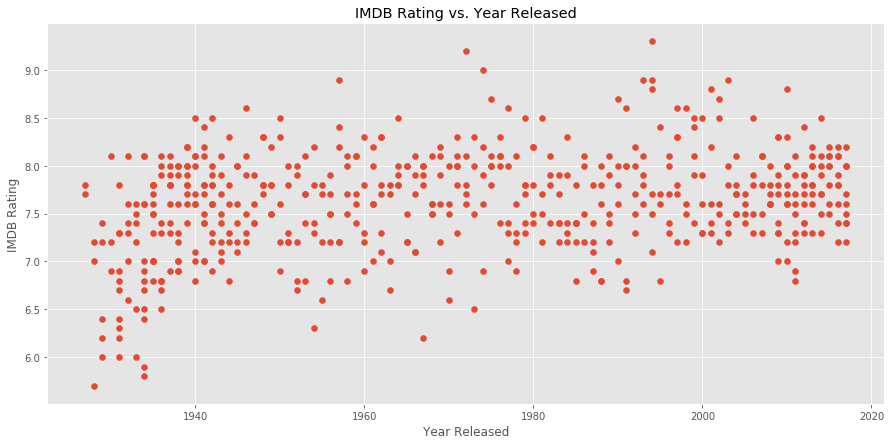

[[1.         0.27688301]
 [0.27688301 1.        ]]


In [50]:
plt.figure(figsize=(15,7))
plt.scatter(yearvect+1927,ratevect)
plt.title("IMDB Rating vs. Year Released")
plt.xlabel("Year Released")
plt.ylabel("IMDB Rating")
plt.show()

print(np.corrcoef(ratevect,yearvect))

The above scatterplot plots year of release on the $x$-axis vs. IMDB rating on the $y$-axis. As we can see from the plot, ratings are relatively homogenous over the decades, although there are a few trends that we take note of. Movies prior to 1940 seem to have a lower rating on average than the rest, and movies within the past ten or so years have noticeably less variation in their ratings. The largest amount of variation in ratings occurs roughly between 1955 and 1995.

There is a weak correlation between year of release and IMDB rating - nominated movies from later years tend to have a higher rating.

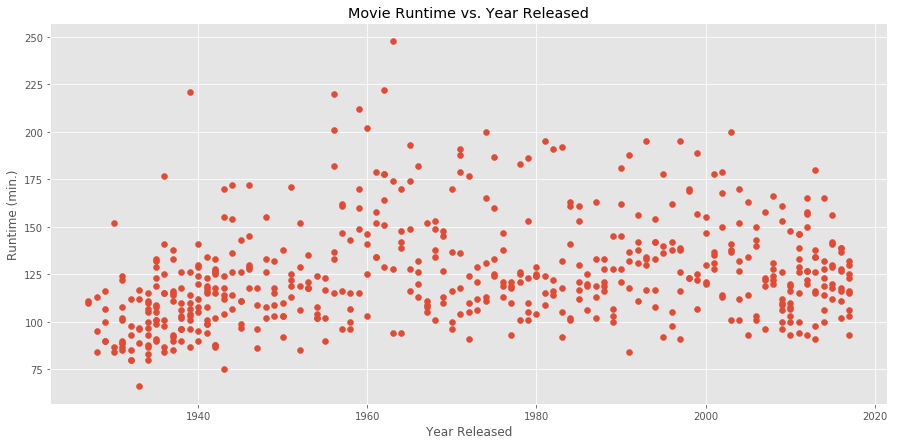

[[1.         0.24389636]
 [0.24389636 1.        ]]


In [51]:
plt.figure(figsize=(15,7))
plt.scatter(yearvect+1927,timevect)
plt.title("Movie Runtime vs. Year Released")
plt.xlabel("Year Released")
plt.ylabel("Runtime (min.)")
plt.show()

print(np.corrcoef(yearvect,timevect))

As we can see from the above scatterplot, movie length (runtime) seems to have some relationship with year of release, with movies prior to 1958 or so having noticeably shorter runtimes on average than those after 1958. From 1970 onwards, the distribution of runtimes relative to year of release appears very homogenous.

There is a weak correlation between year of release and runtime - nominated movies from later years tend to be longer.

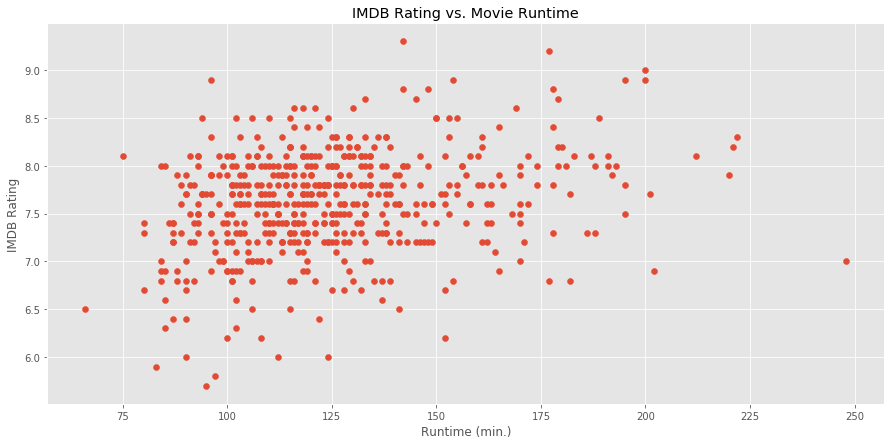

In [52]:
plt.figure(figsize=(15,7))
plt.scatter(timevect,ratevect)
plt.title("IMDB Rating vs. Movie Runtime")
plt.xlabel("Runtime (min.)")
plt.ylabel("IMDB Rating")
plt.show()

In [53]:
# sqrt(r^2) from regression
linReg = LinearRegression()
linReg.fit(timevect.reshape(-1,1),ratevect)
fitted = linReg.predict(timevect.reshape(-1,1))
print(np.sqrt(sk.metrics.r2_score(ratevect,fitted)))

# directly calculate correlation
print(np.corrcoef(ratevect,timevect))

0.26824590310814816
[[1.        0.2682459]
 [0.2682459 1.       ]]


There appears to be somewhat of a positive correlation ($r=0.268$) between movie runtime and rating; among movies nominated for an Academy Award, longer ones seem to enjoy a slight advantage when it comes to rating.

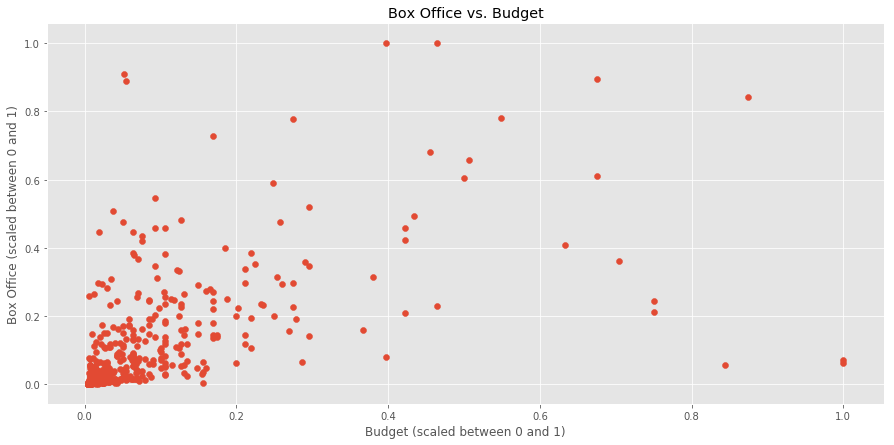

In [54]:
plt.figure(figsize=(15,7))
# create vectors for budget and box office (training + test data combined)
budvect = trainbudvect + testbudvect
boxvect = trainboxvect + testboxvect

plt.scatter(budvect,boxvect)
plt.title("Box Office vs. Budget")
plt.xlabel("Budget (scaled between 0 and 1)")
plt.ylabel("Box Office (scaled between 0 and 1)")
plt.show()

In [55]:
np.corrcoef(budvect,boxvect)

array([[1.        , 0.58300722],
       [0.58300722, 1.        ]])

As one might expect, there is a medium-strength correlation between the movies' budget and box office return ($r=0.583$). Note that the budget and box office figures have been rescaled to be between 0 and 1 (for each movie, its budget/box office is divided by the maximum budget/box office among all movies). The majority of movies have relatively low budget and box office figures compared to the maximum (less than 20% of the maximum budget and less than 40% of the maximum box office).

## Visualizations of the response variable with the predictors

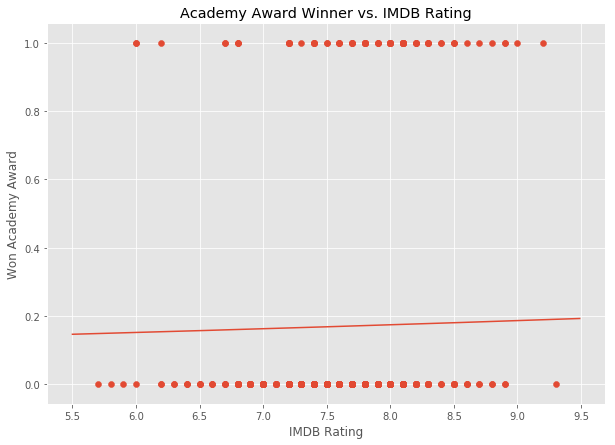

In [56]:
plt.figure(figsize=(10,7))
plt.scatter(ratevect,resp)
clf1 = sk.linear_model.LogisticRegression()
clf1.fit(ratevect.reshape(-1,1),resp)
# fitted = clf1.predict_proba(ratevect.reshape(-1,1))[:,1]

xvals = np.arange(5.5,9.5,0.01)
fitted = clf1.predict_proba(xvals.reshape(-1,1))[:,1]
plt.plot(xvals,fitted)

plt.title("Academy Award Winner vs. IMDB Rating")
plt.xlabel("IMDB Rating")
plt.ylabel("Won Academy Award")
plt.show()

Using logistic regression, we see that there is a slight relationship between IMDB rating and whether a movie won the Academy Award, though perhaps not as much as we would expect. (An interval of 0 to 100, though meaningless, shows the logistic curve with the familiar 'S' shape.)

Next, let's take a look at the relationship between runtime and whether a nominated film won the Academy Award.

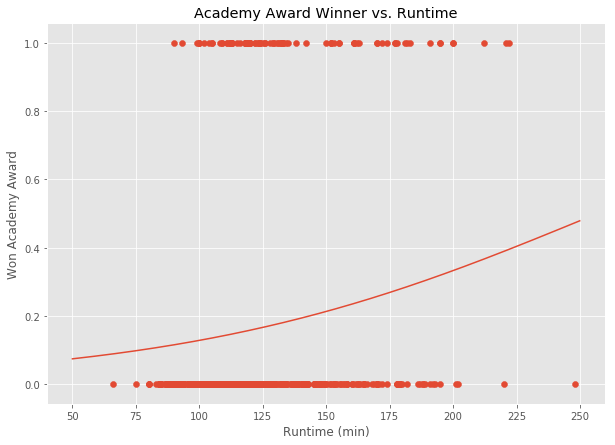

In [57]:
plt.figure(figsize=(10,7))
plt.scatter(timevect,resp)
clf = sk.linear_model.LogisticRegression()
clf.fit(timevect.reshape(-1,1),resp)

xvals = np.arange(50,250,0.1)
fitted = clf.predict_proba(xvals.reshape(-1,1))[:,1]
plt.plot(xvals,fitted)
plt.title("Academy Award Winner vs. Runtime")
plt.xlabel("Runtime (min)")
plt.ylabel("Won Academy Award")
plt.show()

Interestingly, there appears to be a noticeable relationship between a nominated movie's runtime and whether it won the Academy Award: longer movies were more often winners.

Next, let's take a look at the relationship between budget/box office and whether a nominated film won the Academy Award.

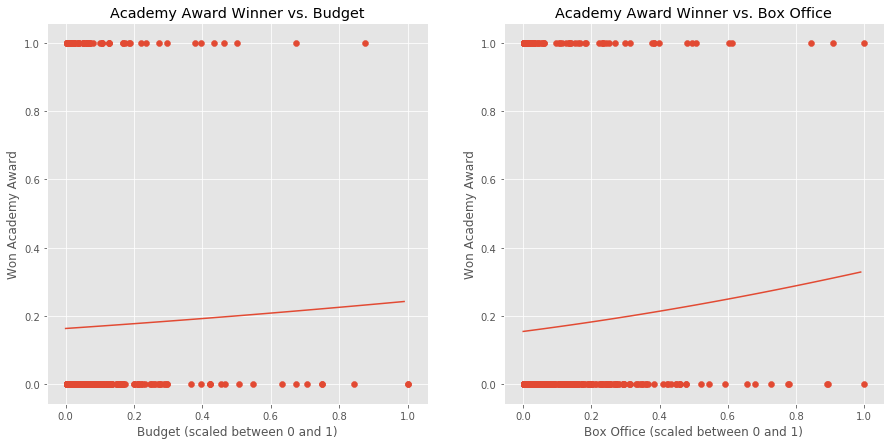

In [58]:
plt.figure(figsize=(15,7))

# budget
plt.subplot(1,2,1)
plt.scatter(budvect,resp)
clf2 = sk.linear_model.LogisticRegression()
clf2.fit(np.array(budvect).reshape(-1,1),resp)
xvals = np.arange(0,1,0.01)
fitted = clf2.predict_proba(xvals.reshape(-1,1))[:,1]
plt.plot(xvals,fitted)
plt.title("Academy Award Winner vs. Budget")
plt.xlabel("Budget (scaled between 0 and 1)")
plt.ylabel("Won Academy Award")

# box office
plt.subplot(1,2,2)
plt.scatter(boxvect,resp)
clf3 = sk.linear_model.LogisticRegression()
clf3.fit(np.array(boxvect).reshape(-1,1),resp)
xvals = np.arange(0,1,0.01)
fitted = clf3.predict_proba(xvals.reshape(-1,1))[:,1]
plt.plot(xvals,fitted)
plt.title("Academy Award Winner vs. Box Office")
plt.xlabel("Box Office (scaled between 0 and 1)")
plt.ylabel("Won Academy Award")

plt.show()

We see that there is a positive relationship between a nominated movie's budget/box office and whether it won the Academy Award; of the two, box office has a stronger relationship. Intuitively, this is a reasonable conclusion since although budget correlates with box office, a movie's box office figure is decided after the movie is released, and is based on the quality of the movie as well as its popularity. Box office appears to also have a stronger relationship with the response than the IMDB rating does.

Next, let's look at how the winners are divided by genre.

In [59]:
genreList = data[:,14]

# total number of occurrences of each genre
genreCounts = {}
for i in range(len(genreList)):
    for genre in genreList[i]:
        if genre in genreCounts.keys():
            genreCounts[genre] += 1
        elif genre not in genreCounts.keys():
            genreCounts[genre] = 1

# number of wins for each genre
genreWinCounts = {}
for i in range(len(genreList)):
    for genre in genreList[i]:
        if genre in genreWinCounts.keys():
            if resp[i] == 1:
                genreWinCounts[genre] += 1
        elif genre not in genreWinCounts.keys():
            if resp[i] == 1:
                genreWinCounts[genre] = 1
                
# need to clean up a bit... e.g., 'Dra' should be 'Drama', etc.
genreCounts[' Drama'] += genreCounts[' Dra'] + genreCounts['Drama']
del genreCounts[' Dra']
del genreCounts['Drama']
genreCounts[' Comedy'] += genreCounts['Comedy']
del genreCounts['Comedy']
genreCounts[' Fantasy'] += genreCounts[' Fanta']
del genreCounts[' Fanta']
genreCounts[' Sci-Fi'] += genreCounts[' Sci-'] + genreCounts['Sci fi']
del genreCounts['Sci fi']
del genreCounts[' Sci-']
genreCounts[' Horror'] += genreCounts[' Horr']
del genreCounts[' Horr']
genreCounts[' Film-Noir'] += genreCounts[' Film-No']
del genreCounts[' Film-No']
genreCounts[' Crime'] += genreCounts[' Cri'] + genreCounts['Crime']
del genreCounts[' Cri']
del genreCounts['Crime']
genreCounts[' Western'] += genreCounts[' W'] + genreCounts[' Weste']
del genreCounts[' W']
del genreCounts[' Weste']
genreCounts[' Mystery'] += genreCounts[' Myste']
del genreCounts[' Myste']
genreCounts[' Family'] += genreCounts[' Fami']
del genreCounts[' Fami']
genreCounts[' History'] += genreCounts[' Histo']
del genreCounts[' Histo']
genreCounts[' Sport'] += genreCounts[' Spo']
del genreCounts[' Spo']
genreCounts[' Musical'] += genreCounts[' Music']
del genreCounts[' Music']
genreCounts[' Action'] += genreCounts['Action']
del genreCounts['Action']
genreCounts[' Adventure'] += genreCounts['Adventure']
del genreCounts['Adventure']
genreCounts[' Romance'] += genreCounts[' Roman']
del genreCounts[' Roman']

genreWinCounts[' Film-Noir'] += genreWinCounts[' Film-No']
del genreWinCounts[' Film-No']
genreWinCounts[' Western'] += genreWinCounts[' Weste'] + genreWinCounts[' W']
del genreWinCounts[' Weste']
del genreWinCounts[' W']
genreWinCounts[' Family'] += genreWinCounts[' Fami']
del genreWinCounts[' Fami']
genreWinCounts[' Mystery'] += genreWinCounts[' Myste']
del genreWinCounts[' Myste']
genreWinCounts[' Crime'] += genreWinCounts['Crime']
del genreWinCounts['Crime']
genreWinCounts[' Musical'] += genreWinCounts[' Music']
del genreWinCounts[' Music']
genreWinCounts[' Drama'] += genreWinCounts[' Dra'] + genreWinCounts['Drama']
del genreWinCounts[' Dra']
del genreWinCounts['Drama']
genreWinCounts[' Romance'] += genreWinCounts[' Roman']
del genreWinCounts[' Roman']

In [60]:
print(genreCounts)
print(genreWinCounts)

{' Drama': 477, ' Biography': 102, ' History': 70, ' Action': 26, ' Horror': 2, ' Mystery': 24, ' Thriller': 30, ' Adventure': 62, ' Fantasy': 26, ' Comedy': 115, ' Romance': 169, ' Crime': 64, ' Sci-Fi': 9, ' Western': 16, ' Musical': 51, ' Family': 25, ' Sport': 10, ' War': 39, ' Animation': 3, ' Thrill': 3, ' Film-Noir': 14, ' Political': 1}
{' Adventure': 10, ' Drama': 84, ' Fantasy': 2, ' Crime': 13, ' History': 13, ' Comedy': 15, ' Biography': 18, ' Thriller': 6, ' Romance': 25, ' Sport': 3, ' Musical': 9, ' Action': 2, ' War': 10, ' Western': 5, ' Family': 6, ' Film-Noir': 2, ' Mystery': 2}


Above are counts of the number of occurrances of each genre in Academy Award nominees. This is followed by the occurances of each genre in academy award winning movies.

In [61]:
# number of losses for each genre
genreLossCounts = dict(genreCounts)
for genre in genreCounts:
    if genre in genreWinCounts.keys():
        genreLossCounts[genre] -= genreWinCounts[genre]
print(genreLossCounts)

{' Drama': 393, ' Biography': 84, ' History': 57, ' Action': 24, ' Horror': 2, ' Mystery': 22, ' Thriller': 24, ' Adventure': 52, ' Fantasy': 24, ' Comedy': 100, ' Romance': 144, ' Crime': 51, ' Sci-Fi': 9, ' Western': 11, ' Musical': 42, ' Family': 19, ' Sport': 7, ' War': 29, ' Animation': 3, ' Thrill': 3, ' Film-Noir': 12, ' Political': 1}


Above are counts of the number of occurances of each genre in Academy Award nominated movies that lost.

In [62]:
# need to make the win counts in a format that can be plotted properly...
# i.e., same order of genres, some with zeroes
genreWinCountsPlot = dict(genreCounts)
for genre in genreCounts:
    if genre in genreWinCounts.keys():
        genreWinCountsPlot[genre] = genreWinCounts[genre]
    else:
        genreWinCountsPlot[genre] = 0
print(genreWinCountsPlot)

{' Drama': 84, ' Biography': 18, ' History': 13, ' Action': 2, ' Horror': 0, ' Mystery': 2, ' Thriller': 6, ' Adventure': 10, ' Fantasy': 2, ' Comedy': 15, ' Romance': 25, ' Crime': 13, ' Sci-Fi': 0, ' Western': 5, ' Musical': 9, ' Family': 6, ' Sport': 3, ' War': 10, ' Animation': 0, ' Thrill': 0, ' Film-Noir': 2, ' Political': 0}


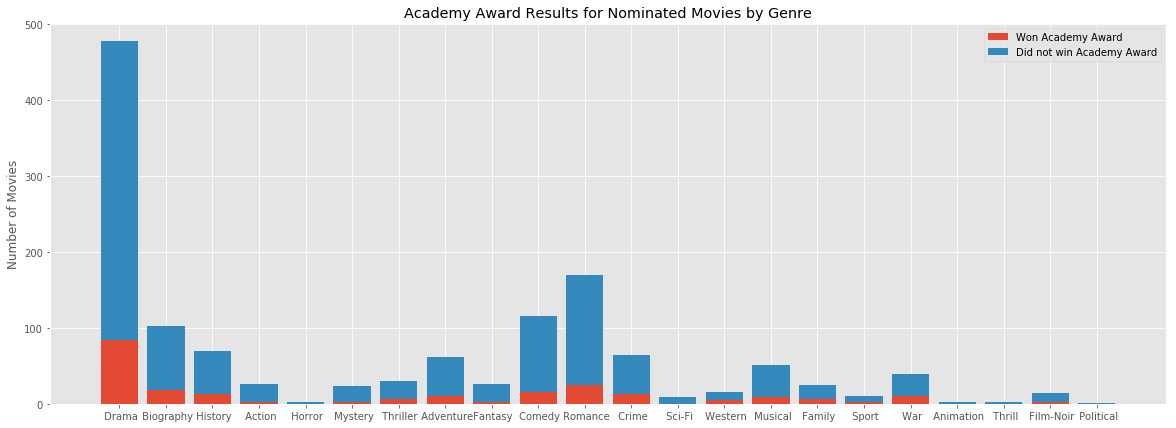

,Genre,Win Percentage
0,Drama,0.176101
1,Biography,0.176471
2,History,0.185714
3,Action,0.076923
4,Horror,0.000000
5,Mystery,0.083333
6,Thriller,0.200000
7,Adventure,0.161290
8,Fantasy,0.076923
9,Comedy,0.130435


In [63]:
# plot it
plt.figure(figsize=(20,7))

p1 = plt.bar(range(len(genreWinCountsPlot)),list(genreWinCountsPlot.values()))
p2 = plt.bar(range(len(genreLossCounts)),list(genreLossCounts.values()),bottom=list(genreWinCountsPlot.values()))
plt.title("Academy Award Results for Nominated Movies by Genre")
plt.xticks(range(len(genreWinCountsPlot)),list(genreWinCountsPlot.keys()))
plt.ylabel("Number of Movies")
plt.legend((p1[0],p2[0]),("Won Academy Award","Did not win Academy Award"))

plt.show()

# calculate winning percentage for each genre
genrePercents = dict(genreWinCountsPlot)
for genre in genrePercents:
    genrePercents[genre] = genreWinCountsPlot[genre]/genreCounts[genre]
df = pd.DataFrame(list(genrePercents.items()),columns=["Genre", "Win Percentage"])
df

First, we should note that many movies in our dataset have multiple genres. For the purposes of this visualization, all the genres of a movie are assigned a 'win' or a 'loss' depending on whether the movie won the Academy Award that year.

It is immediately apparent that Drama is by far the most popular genre among nominated movies with over double the number of movies categorized as Drama comapred to the next-most popular genre (Romance). The overall win percentage is $\frac{90}{546}=16.5\%$.

Romance (14.8%) and Comedy (13.0%) movies both have a below-average winrate despite fairly large sample sizes (169 and 115 respectively), while Drama (17.6%), Biography (17.6%), History (18.6%), and Crime (20.3%) all enjoy somewhat above-average winrates (sample sizes of 477, 102, 70, and 64, respectively).

Two particular standouts genre are War and Western - war movies enjoy a winrate of 25.6% with a respectable sample size of 39, while Westerns have had a winrate of 31.2%, though with a small sample size (16).

Action movies have performed poorly, with a 7.7% winrate out of 26 nominations.

Five genres have movies that were nominated for an Academy Award, but have not yet won - these are Horror, Sci-Fi, Animation, Thrill, and Political. Among these, sci-fi movies have had the most opportunities, with 9 nominations being classified as sci-fi over the years.

Next, let's take a look at how the winners were distributed by language.

90 0 451 5


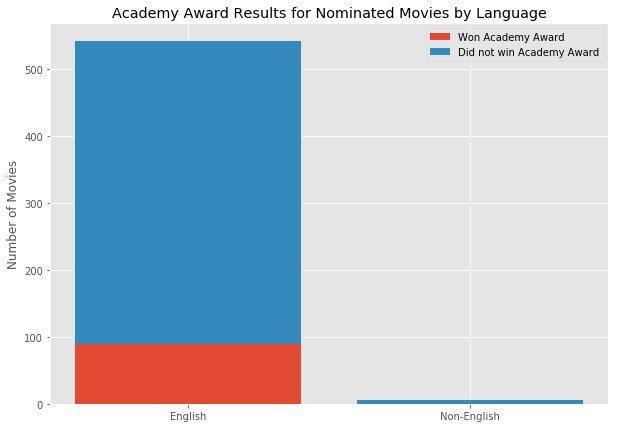

In [64]:
plt.figure(figsize=(10,7))

langType = langvect[:,0]

numEnglishWinners = 0
numForeignWinners = 0
numEnglishLosers = 0
numForeignLosers = 0
for i in range(len(langType)):
    if langType[i] == 1 and resp[i] == 1:
        numEnglishWinners += 1
    elif langType[i] == 1 and resp[i] == 0:
        numEnglishLosers += 1
    elif langType[i] == 0 and resp[i] == 1:
        numForeignWinners += 1
    elif langType[i] == 0 and resp[i] == 0:
        numForeignLosers += 1
    
print(numEnglishWinners,numForeignWinners,numEnglishLosers,numForeignLosers)

p1 = plt.bar([0,1],[numEnglishWinners,numForeignWinners])
p2 = plt.bar([0,1],[numEnglishLosers,numForeignLosers],bottom=[numEnglishWinners,numForeignWinners])
plt.title("Academy Award Results for Nominated Movies by Language")
plt.xticks([0,1],("English", "Non-English"))
plt.ylabel("Number of Movies")
plt.legend((p1[0],p2[0]),("Won Academy Award","Did not win Academy Award"))
plt.show()

As we can see, there were only five non-English movies that were nominated for an Academy Award, and none of them ended up winning. Of the 541 English-language movies, there were 90 winners, representing 16.6% of that total number.

In [65]:
# import pandas as pd
# from pandas.plotting import scatter_matrix

# scatter_matrix(pd.DataFrame(np.column_stack((yearvect+1927, timevect, ratevect, budvect,boxvect))), alpha=1,figsize=(25,25))

# Logistic Regression
In this section, we perform logistic regression using a subset of the variables to determine which ones are significant in predicting whether a nominated movie wins the Academy Award.

In [66]:
# budget, box office, language, runtime, year, rating
xvars = np.column_stack((budvect,boxvect,langType,timevect,yearvect,ratevect))
logReg = sm.Logit(resp,xvars)
print(logReg.fit().summary2())

Optimization terminated successfully.
         Current function value: 0.435600
         Iterations 6
                        Results: Logit
Model:              Logit            Pseudo R-squared: 0.027   
Dependent Variable: y                AIC:              487.6751
Date:               2018-06-01 18:55 BIC:              513.4909
No. Observations:   546              Log-Likelihood:   -237.84 
Df Model:           5                LL-Null:          -244.39 
Df Residuals:       540              LLR p-value:      0.022409
Converged:          1.0000           Scale:            1.0000  
No. Iterations:     6.0000                                     
-----------------------------------------------------------------
         Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-----------------------------------------------------------------
x1      -0.1023     1.0668   -0.0959   0.9236   -2.1933    1.9886
x2       1.4992     0.7994    1.8755   0.0607   -0.0675    3.0659
x3      -1.8714  

From the output, we see that the first variable, budget, is the least significant one in the presence of the other variables. Let's remove it and run the logistic regression again:

In [67]:
# box office, language, runtime, year, rating
xvars = np.column_stack((boxvect,langType,timevect,yearvect,ratevect))
logReg = sm.Logit(resp,xvars)
print(logReg.fit().summary2())

Optimization terminated successfully.
         Current function value: 0.435608
         Iterations 6
                        Results: Logit
Model:              Logit            Pseudo R-squared: 0.027   
Dependent Variable: y                AIC:              485.6844
Date:               2018-06-01 18:55 BIC:              507.1975
No. Observations:   546              Log-Likelihood:   -237.84 
Df Model:           4                LL-Null:          -244.39 
Df Residuals:       541              LLR p-value:      0.010815
Converged:          1.0000           Scale:            1.0000  
No. Iterations:     6.0000                                     
-----------------------------------------------------------------
         Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-----------------------------------------------------------------
x1       1.4517     0.6285    2.3098   0.0209    0.2199    2.6834
x2      -1.8736     0.8030   -2.3333   0.0196   -3.4475   -0.2998
x3       0.0152  

The fourth variable, year, is not significant in the presence of the other variables. Let's remove it and run the logistic regression again:

In [68]:
# box office, language, runtime, rating
xvars = np.column_stack((boxvect,langType,timevect,ratevect))
logReg = sm.Logit(resp,xvars)
print(logReg.fit().summary2())

Optimization terminated successfully.
         Current function value: 0.435880
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.026    
Dependent Variable: y                AIC:              483.9808 
Date:               2018-06-01 18:55 BIC:              501.1913 
No. Observations:   546              Log-Likelihood:   -237.99  
Df Model:           3                LL-Null:          -244.39  
Df Residuals:       542              LLR p-value:      0.0050898
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     6.0000                                      
------------------------------------------------------------------
          Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
------------------------------------------------------------------
x1        1.4708     0.6274    2.3443   0.0191    0.2411    2.7004
x2       -1.8052     0.7925   -2.2777   0.0227   -3.3586   -0.2518
x3 

The remaining four variables - box office, language, runtime, and rating - are all significant at the $\alpha=0.05$ level, with runtime being the most significant of the four in the presence of the other variables. This is a consistent result with our preliminary univariate logistic analysis from earlier.

# Similarity Kernel Construction
In this section, a kernel is constructed for the data in datavec. The radial basis function and it represents a measure of simularity between the movies. The radial basis function between two vectors (in this case movies) for a parameter $\gamma$ is given by $$k(x_i,x_j) = e^{-\gamma \left| \left|x_i-x_j \right| \right|_2^2}.$$ The $\gamma$ is set to 1/number of features. The simularity submatrix for the training set and test set are created. The training set kernel simularity matrix is a matrix which describes the simularity between movies in the training set. The test set kernel simularity matrix measures the simularity between the test set and the movies in the training set. 

In [69]:
from sklearn.metrics.pairwise import rbf_kernel
trainsimkernel = rbf_kernel(traindatavect)
trainsimkernel.shape

(382, 382)

In [70]:
train.shape
testsimkernel = rbf_kernel(testdatavect,traindatavect)
testsimkernel.shape

(164, 382)

The term $\left| \left|x_i-x_j \right| \right|_2^2 = \sum_{k=1}^m (x_{ik}-x_{jk})^2$ where m is the number of features of datavect. The kth term in this sum is zero if $x_{ik}=x_{jk}$. The number of features is very large due to the size of plotvect. However, the number of features where $x_{ik}\neq x_{jk}$ is much smaller. This is due to the sparsity of the plotvec matrix. 

# Classification

## Support Vector Machine

In [79]:
from sklearn.svm import SVC
machine = SVC(kernel="precomputed",probability=True)
machine.fit(trainsimkernel,trainresp)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto',
  kernel='precomputed', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [80]:
from sklearn.metrics import roc_curve 

print(machine.classes_)
probpred = machine.predict_proba(testsimkernel)
probpred = [probpred[i][1] for i in range(probpred.shape[0])] #predictions of winners
fpr, tpr, _ = roc_curve(testresp, probpred)


[0 1]


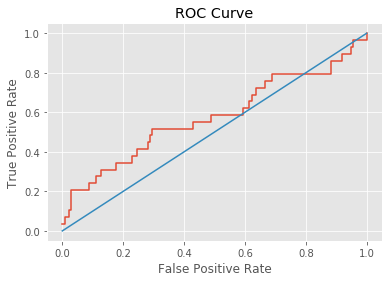

In [81]:
import matplotlib.pyplot as py
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1])
plt.title("ROC Curve")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

As seen above, the Support Vector machine is not very successful compared to random guessing. Although, it is slightly better than random guessing for most threshold values.  Potentially challenges that lead to this algorithms under performace are noted in the conlcusion. Its performance is probably the worst amoung considered algorithms. Examining the PR curve confirms that the performance is quite poor overall.

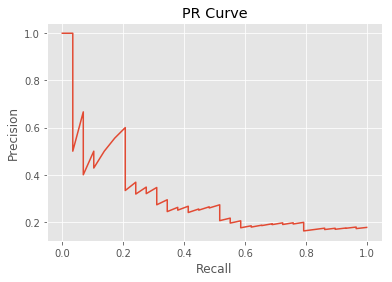

In [82]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(testresp, probpred)
py.plot(recall,precision)
py.title("PR Curve")
py.xlabel("Recall")
py.ylabel("Precision")
py.show()

## K-Nearest Neighbors Classifcation

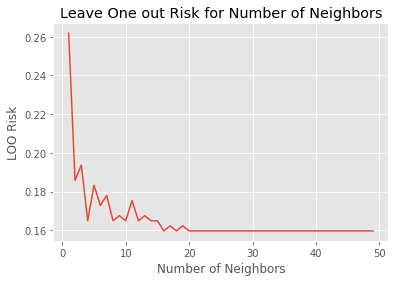

In [162]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import LeaveOneOut
def loo_risk(X,y,k): # Adjusted from CODE WRITTEN BY PROF. SHARPNACK
    """
    Construct the leave-one-out square error risk for a KNN model with k neighbors
    
    Input: design matrix, X, response vector, y,number of neighbors
    Output: scalar LOO risk
    """
    KNNclass = KNN(n_neighbors=k)
    loo = LeaveOneOut()
    loo_losses = []
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        KNNclass.fit(X_train,y_train)
        y_hat = KNNclass.predict(X_test)
        loss = np.sum((y_hat - y_test)**2)
        loo_losses.append(loss)
    return np.mean(loo_losses)



ks = [i for i in range(1,50)]
loo = [loo_risk(trainsimkernel,trainresp,i) for i in range(1,50)]
py.plot(ks,loo)
py.title("Leave One out Risk for Number of Neighbors")
py.xlabel("Number of Neighbors")
py.ylabel("LOO Risk")
py.show()

It seems clear from the above that more neighbors are better and there is no real improvement after 20 neighbors.

In [249]:
from sklearn.metrics import roc_curve 
from sklearn.neighbors import KNeighborsClassifier as KNN
KNNclass = KNN(n_neighbors=20)
KNNclass.fit(trainsimkernel,trainresp)
probpred = KNNclass.predict_proba(testsimkernel)
print(KNNclass.classes_)
probpred = [probpred[i][1] for i in range(probpred.shape[0])]
fpr, tpr, _ = roc_curve(testresp, probpred)

[0 1]


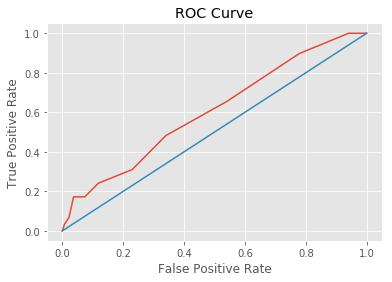

In [250]:
import matplotlib.pyplot as py
py.plot(fpr,tpr)
py.plot([0,1],[0,1])
py.title("ROC Curve")
py.ylabel("True Positive Rate")
py.xlabel("False Positive Rate")
py.show()

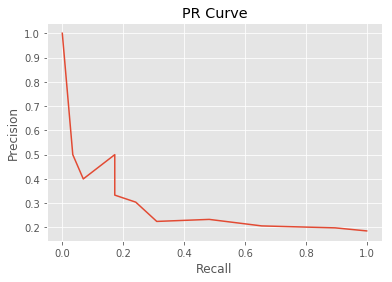

In [251]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(testresp, probpred)
py.plot(recall,precision)
py.title("PR Curve")
py.xlabel("Recall")
py.ylabel("Precision")
py.show()

The key parameter in this algorithm in the number of neighbors used to determine the movies class. Most movies in the dataset did not win the academy award. It seems reasonable that this number of neighbors should be relatively large so as to be sure to capture a representative group of "nearest" neighbors. This parameter is tuned using leave one out cross validation. The leave one out risk decreasing sharply until about 20 nearest neighbors. After 20, the curve is relatively flat. 20 is chosen as the number of neighbors. 

Kth Nearest Neighbors is somewhat successful in predicting academy award winners. The algorithm beats random guessing consistently. This algorithm is more successful than support vector machines, but of course relies on the tuning parameter.

## AdaBoost Classification

Leave One out Risk was too computationally expensive. A 70-30 split of the training set is made and the MSE error in prediction of the test set inside the training set is found.

In [165]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import LeaveOneOut


(267, 382)
(115, 382)


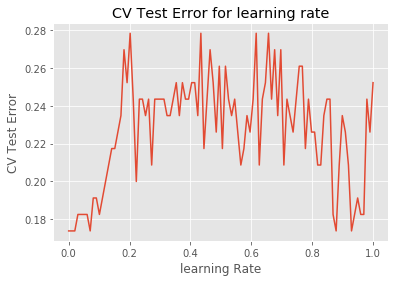

In [166]:
from sklearn.model_selection import train_test_split
train1, train2 = train_test_split(np.column_stack((trainsimkernel, trainresp)), test_size=0.3, random_state=34094482)


resp1 = [train1[i][382] for i in range(train1.shape[0])]
resp2 = [train2[i][382] for i in range(train2.shape[0])]
train1 = np.delete(train1,382,axis=1)
train2 = np.delete(train2,382,axis=1)
print(train1.shape)
print(train2.shape)

ks = np.linspace(.00000001,1,100)
def geterror(i):
    ADA = AdaBoostClassifier(learning_rate=i)
    ADA.fit(train1,resp1)
    y_hat = ADA.predict(train2)
    return np.mean((y_hat - resp2)**2)
err = [geterror(i) for i in ks]
py.plot(ks,err)
py.title("CV Test Error for learning rate")
py.xlabel("learning Rate")
py.ylabel("CV Test Error")
py.show()

This plot indicates that smaller learning rate is better. However, below about .1, there is no significant improvement in CV Test Error. So the learning rate is set to .1.

In [252]:
from sklearn.ensemble import AdaBoostClassifier
ADA = AdaBoostClassifier(learning_rate=.1)
ADA.fit(trainsimkernel,trainresp)
probpred = ADA.predict_proba(testsimkernel)
print(ADA.classes_)
probpred = [probpred[i][1] for i in range(probpred.shape[0])]
fpr, tpr, _ = roc_curve(testresp, probpred)

[0 1]


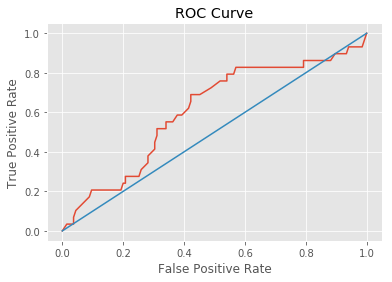

In [253]:
import matplotlib.pyplot as py
py.plot(fpr,tpr)
py.plot([0,1],[0,1])
py.title("ROC Curve")
py.ylabel("True Positive Rate")
py.xlabel("False Positive Rate")
py.show()

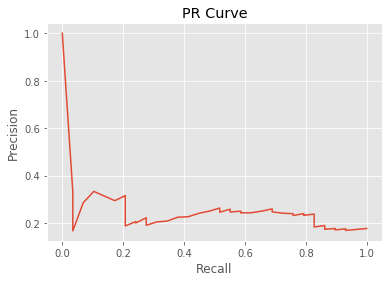

In [254]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(testresp, probpred)
py.plot(recall,precision)
py.title("PR Curve")
py.xlabel("Recall")
py.ylabel("Precision")
py.show()

The learning rate must be tuned in this algorithm. Empirical Risk was not very informative and leave one out risk was not computationally feasible, so a 70-30 split of the training set is made. The algorithm is trained on 70% of the trianing set and its performance is evaluated on the remaining 30% by means of mean squared error. While the plot of this cross validation error does lead to a clear choice of learning rates. It seems that smaller values are superior and .1 is chosen. There appears to be only negligible improvement from learning rates lower than .1. 

The adaboost algorithm is somewhat sucessful in predicting academy award winners. Its ability is comparable to kth nearest neighbors and superior to support vector machines. The algorithm is consistently better than random guessing, but not by a large margin. 

More advanced cross validation and tuning parameter selection techniques  may be able to improve the performance of this algorithm. Compared to other algorithms in this analysis, it performs quite well comparatively already in terms of ROC. The PR curve however is quite poor.

## Random Forest

Empirical Risk was chosen for tuning the number of trees in the forest. Using LOO Risk was too computationally expensive.

In [169]:
from sklearn.ensemble import RandomForestClassifier

def emp_risk(X,y,i):
    """
    Return the empirical risk for square error loss in random forest
    
    Input: design matrix, X, response vector, y, number of trees
    Output: scalar empirical risk
    """
    RFC = RandomForestClassifier(n_estimators=i)
    RFC.fit(X,y)
    y_hat = RFC.predict(X)
    return np.mean((y_hat - y)**2)



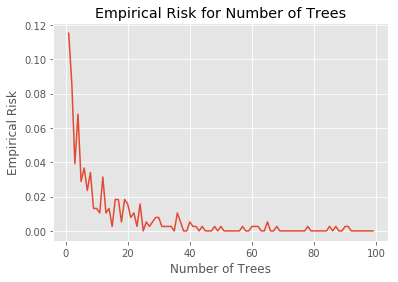

In [170]:
ks = [i for i in range(1,100)]
emp = [emp_risk(trainsimkernel,trainresp,i) for i in range(1,100)]
py.plot(ks,emp)
py.title("Empirical Risk for Number of Trees")
py.xlabel("Number of Trees")
py.ylabel("Empirical Risk")
py.show()

There is little to no improvement after 40 trees. This number is chosen.

In [255]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(40)
RFC.fit(trainsimkernel,trainresp)
probpred = RFC.predict_proba(testsimkernel)
print(RFC.classes_)
probpred = [probpred[i][1] for i in range(probpred.shape[0])]
fpr, tpr, _ = roc_curve(testresp, probpred)

[0 1]


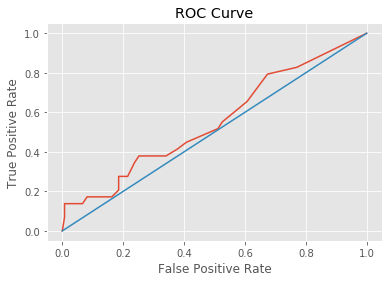

In [256]:
import matplotlib.pyplot as py
py.plot(fpr,tpr)
py.plot([0,1],[0,1])
py.title("ROC Curve")
py.ylabel("True Positive Rate")
py.xlabel("False Positive Rate")
py.show()

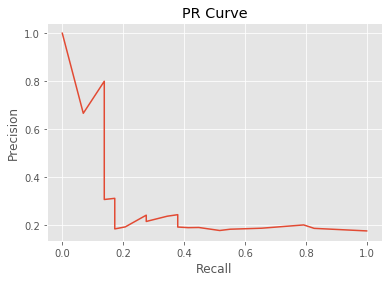

In [257]:

from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(testresp, probpred)
py.plot(recall,precision)
py.title("PR Curve")
py.xlabel("Recall")
py.ylabel("Precision")
py.show()

Random Forest algorithms utilizing bagging and decision trees to make predictions. The number of trees in this forest must be inputed. Empirical Risk is used for this paramter tuning because leave one out risk was not computationally feasible. The empirical risk curve indates that there is little improvement from increasing the number of trees beyond 40. For the sake of lowering computational speed and promoting model simplicity, the number of trees is chosen to be 40. There is little to no improvement in emprirical risk from increasing this parameter. 

This algorithm performs better than random guessing. However, like the other algorithms in this project, it only beats it by a small margin. The algorithm is consistent for all threshold values. The authors would rank this algorithms performance as superior to support vector machines but inferior to Kth nearest neighbors and Adaboost. 

Once again, the PR curve reveals that performance is not very good, as is the case for all PR curves in this analysis. The authors gives some explanations as to why this classification problem may be so difficult in the conclusion.

# Logistic Regression

In [258]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
LR.fit(trainsimkernel,trainresp)
probpred = LR.predict_proba(testsimkernel)
print(LR.classes_)
probpred = [probpred[i][1] for i in range(probpred.shape[0])]
fpr, tpr, _ = roc_curve(testresp, probpred)

[0 1]


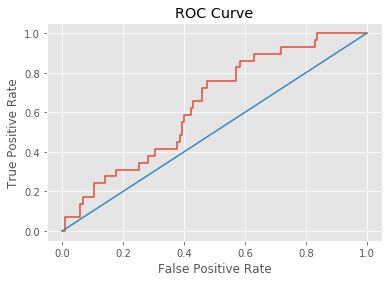

In [259]:
import matplotlib.pyplot as py
py.plot(fpr,tpr)
py.plot([0,1],[0,1])
py.title("ROC Curve")
py.ylabel("True Positive Rate")
py.xlabel("False Positive Rate")
py.show()

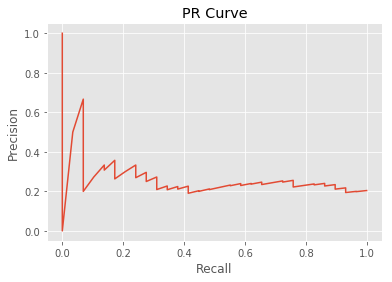

In [260]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(testresp, probpred)
py.plot(recall,precision)
py.title("PR Curve")
py.xlabel("Recall")
py.ylabel("Precision")
py.show()

Note that Logistic Regression was also used above to explore and model the data. Individual significance of variables were explored in that analysis, but only a subset of features were utilized. This logistic regression model uses all features (through a simularity measure).

The authors suggest that Logistic regression is the best performing algorithm of the algorithms explored here. It does not vastly outperform random guessing, but it is quite sucessful considering the difficult nature of classification in this setting and problem. As can be seen in the ROC curve, logistic regression outperforms random guessing for all threshold values. The PR curve indicates, however, that there is still signifcant room for improvement.

# Conclusion

The above analysis shows that it is difficult to predict academy award winners.  Here are some potential challenges in this classification problem: 
Challenges: 
1. Small sample size: Since only one movie wins the award each year, there are few movies to train an algorithm on that are winners. This dataset could be expanded by including non-nominated movies, but these movies would of course not be winners. 
2. Uniqueness: A primary component of this analysis is the use of a simularity measure. However, often the uniqueness and individuality of a plot or film is the very thing that makes it successful. As a result, it can be difficult to predict whether a movie will be successful by comparing it to other successful movies. 
3. Emotion: Many variables affect a movies appeal and sucess. Many of these are subtle or emotional and therfore difficult to quantify. Despite this, all algorithms show some success in predicting academy award winners. 

Despite these challenges, each algorithm beats random guessing (for most threshold values). There is still some variability in academy award victories that can be explained consistently by these algorithms. However, PR cures reveal that there is still significant room for improvement. Here are some potential areas for improvement in future research and work:

1. Larger sample size.
2. More advanced algorithms to deal with the class imbalance. Most movies do not win the academy award so there are far more movies that didnt win than those who did win. A more advanced and complex algorithm may deal with this problem more effectively.
3. More advanced parameter tuning. 
4. More detailed plots, perhaps using scripts instead of summaries.


In summary, this classification problem is a difficult one and it present a variety of challenges. Despite these, a variety of binary classification algorithms do show some promise in predicting academy award winning movies using a variety of features.
